In [ ]:
!pip install ax-platform textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.8/786.8 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import re
import string
from textblob import Word

import itertools
from collections import defaultdict

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from ax.api.client import Client
from ax.api.configs import ChoiceParameterConfig, RangeParameterConfig

[WARNING 12-06 23:42:15] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Data/CSC705_Project/AVC_claims_survey.sql.csv', dtype={'comments': str})

In [ ]:
# Randomly reorder the DataFrame
data = data.sample(frac=1).reset_index(drop=True)
satisfied = data['satisfied']


# Convert the pandas Series y to a torch LongTensor
y_tensor = torch.tensor(satisfied.values, dtype=torch.long)

# Perform one-hot encoding. Since labels are 1-5, we need 6 classes (0-5) to accommodate.
# Then, we'll remove the first column (index 0) which corresponds to a non-existent class.
satisfied_oh = F.one_hot(y_tensor, num_classes=6)[:, 1:]

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
data['comments'] = data['comments'].astype(str).fillna('')
# Split on any character that is NOT a word character (alphanumeric) or is an underscore.
# This effectively isolates all punctuation and symbols.
pattern = r'(\W|_)'
comments = [re.split(pattern, text.lower()) for text in data['comments']]
comments = [
    [item.strip() for item in sublist if item.strip()]
    for sublist in comments
]
comments = [
    [Word(item).lemmatize() for item in sublist]
    for sublist in comments
]

In [ ]:
# Display unique tokens to verify separation
all_words = sorted(set(list(itertools.chain.from_iterable(comments))))

In [ ]:
vocab = {i:t for i, t in enumerate(all_words)}
lookup = {token:integer for integer,token in vocab.items()}

In [ ]:
encoded = [
    [lookup[token] for token in comment]
    for comment in comments
]
print([e[:5] for e in encoded])

[[10645, 1331, 4792, 1702, 10148], [10678, 11572, 10375, 7474, 1205], [7685, 11003, 7640, 10645, 8507], [10684, 11568, 11528, 6, 6605], [11602, 5553, 4538, 7327, 2522], [5553, 5464, 10785, 7450, 4331], [7327, 948, 11444, 11358, 5012], [5553, 11444, 7449, 5645, 7327], [10706, 7327, 11330, 11444, 800], [5997, 11444, 3549, 10785, 10321], [10691, 2522, 6797, 6999, 10405], [5553, 5279, 1743, 4722, 1504], [4256, 9648, 789, 6290, 8953], [5997, 11444, 11358, 3941, 3745], [1765, 7327, 4580, 857, 11], [5553, 11444, 11358, 9458, 11691], [5285, 8497, 4668, 10645, 11391], [800, 1153, 11, 9382, 11444], [7327, 1031, 11444, 11722, 1205], [7545, 4668, 1563, 800, 5553], [10691, 11444, 7327, 4580, 10754], [4580, 10754, 5645, 800, 6646], [7327, 11629, 4331, 7685, 10691], [7349, 1504, 1505, 11444, 5764], [10645, 857, 7622, 5645, 7568], [6878, 8578, 11444, 7770, 5711], [62, 13, 5234, 10754, 4938], [5553, 1140, 5279, 10797, 7988], [1142, 2685, 5377, 12, 10538], [5723, 10639, 9130, 3209, 11444], [1101, 1462, 

In [ ]:
encoded = [torch.LongTensor(e) for e in encoded]

In [ ]:
padded = pad_sequence(encoded, batch_first=True, padding_value=0).long()

In [ ]:
from sklearn.model_selection import train_test_split

# Split the encoded comments and satisfied_oh labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    encoded, satisfied_oh, test_size=0.2, random_state=42
)

print(f"Training comments size: {len(X_train)}")
print(f"Testing comments size: {len(X_test)}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training comments size: 8559
Testing comments size: 2140
Training labels shape: torch.Size([8559, 5])
Testing labels shape: torch.Size([2140, 5])


In [ ]:
import numpy as np

comment_lengths = [len(comment) for comment in comments]

mean_length = np.mean(comment_lengths)
median_length = np.median(comment_lengths)

print(f"Mean comment length: {mean_length:.2f} words")
print(f"Median comment length: {median_length:.2f} words")

Mean comment length: 53.84 words
Median comment length: 37.00 words


In [ ]:
class GRU_nn(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim, hidden_size, num_layers, output_size):
        super(GRU_nn, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocabulary_size, embedding_dim)

        # GRU layer, input_size is now embedding_dim
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)

        # Fully connected layer to get the final output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x)

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate the GRU
        out, _ = self.gru(x, h0)  # out: batch_size, seq_len, hidden_size

        # Take the output from the last time step
        out = out[:, -1, :]

        # Pass through the fully connected layer
        out = self.fc(out)
        # Apply sigmoid to output for BCELoss, as it expects probabilities
        out = torch.sigmoid(out)
        return out

In [ ]:
class TextDataset(Dataset):
    def __init__(self, encoded_texts, labels):
        self.encodings = [torch.tensor(seq, dtype=torch.long) for seq in encoded_texts]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.encodings[idx], self.labels[idx]

In [ ]:
def collate_batch(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded_texts, torch.stack(labels)

In [ ]:
#Ax configuration
client = Client()
parameters = [
    RangeParameterConfig(
        name="hidden_size", parameter_type="int", bounds=(5, 20)
    ),
    RangeParameterConfig(
        name="num_layers", parameter_type="int", bounds=(1, 5)
    ),
    ChoiceParameterConfig(
        name="learning_rate",
        parameter_type="float",
        values=(0.0001, 0.001, 0.01),
        is_ordered=True
    ),
]

client.configure_experiment(parameters=parameters)

metric_name = "loss"
client.configure_optimization(objective=f"-{metric_name}")

In [ ]:
embedding_dim = 100
hidden_size = 20
num_layers = 1
output_size = 5
vocabulary_size = len(vocab)
learning_rate = 0.01

losses = defaultdict(list)

for i in range(10):
    trials = client.get_next_trials(max_trials=3)

    for trial_index, parameters in trials.items():
        hidden_size = parameters["hidden_size"]
        num_layers = parameters["num_layers"]
        learning_rate = parameters["learning_rate"]

        print("Hyperparameters: ", hidden_size, num_layers, learning_rate)

        dataset = TextDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

        model = GRU_nn(len(vocab), embedding_dim, hidden_size, num_layers, output_size).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        num_epochs = 3

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for batch_idx, (X, y) in enumerate(dataloader):
                X = X.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                outputs = model(X)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            losses[(i, trial_index, hidden_size, num_layers, learning_rate)].append(total_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

        print("Training completed.")

        # Set raw_data as a dictionary with metric names as keys and results as values
        raw_data = {metric_name: total_loss}

        # Complete the trial with the result
        client.complete_trial(trial_index=trial_index, raw_data=raw_data)

[INFO 12-06 23:43:12] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 12-06 23:43:12] ax.api.client: Generated new trial 0 with parameters {'hidden_size': 12, 'num_layers': 3, 'learning_rate': 0.001} using GenerationNode CenterOfSearchSpace.
[INFO 12-06 23:43:12] ax.api.client: Generated new trial 1 with parameters {'hidden_size': 12, 'num_layers': 4, 'learning_rate': 0.0001} using GenerationNode Sobol.
[INFO 12-06 23:43:12] ax.api.client: Generated new trial 2 with parameters {'hidden_size': 16, 'num_layers': 2, 'learning_rate': 0.01} us

Hyperparameters:  12 3 0.001
Epoch [1/3], Loss: 1505.8386
Epoch [2/3], Loss: 1243.2649


[INFO 12-06 23:44:03] ax.api.client: Trial 0 marked COMPLETED.


Epoch [3/3], Loss: 1143.1287
Training completed.
Hyperparameters:  12 4 0.0001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1847.1914
Epoch [2/3], Loss: 1582.6849


[INFO 12-06 23:44:52] ax.api.client: Trial 1 marked COMPLETED.


Epoch [3/3], Loss: 1539.3656
Training completed.
Hyperparameters:  16 2 0.01


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1399.6032
Epoch [2/3], Loss: 1295.3103


[INFO 12-06 23:45:32] ax.api.client: Trial 2 marked COMPLETED.
[INFO 12-06 23:45:32] ax.api.client: Generated new trial 3 with parameters {'hidden_size': 20, 'num_layers': 5, 'learning_rate': 0.001} using GenerationNode Sobol.
[INFO 12-06 23:45:32] ax.api.client: Generated new trial 4 with parameters {'hidden_size': 8, 'num_layers': 3, 'learning_rate': 0.01} using GenerationNode Sobol.
[WARNING 12-06 23:45:32] ax.api.client: 3 trials requested but only 2 could be generated.


Epoch [3/3], Loss: 1265.1906
Training completed.
Hyperparameters:  20 5 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1454.4488
Epoch [2/3], Loss: 1218.5039


[INFO 12-06 23:46:24] ax.api.client: Trial 3 marked COMPLETED.


Epoch [3/3], Loss: 1118.3062
Training completed.
Hyperparameters:  8 3 0.01


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1449.6601
Epoch [2/3], Loss: 1342.4539


[INFO 12-06 23:47:07] ax.api.client: Trial 4 marked COMPLETED.


Epoch [3/3], Loss: 1292.2500
Training completed.


[INFO 12-06 23:47:08] ax.api.client: Generated new trial 5 with parameters {'hidden_size': 5, 'num_layers': 5, 'learning_rate': 0.001} using GenerationNode MBM.
[WARNING 12-06 23:47:08] ax.api.client: 3 trials requested but only 1 could be generated.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  5 5 0.001
Epoch [1/3], Loss: 1629.2675
Epoch [2/3], Loss: 1313.7129


[INFO 12-06 23:48:00] ax.api.client: Trial 5 marked COMPLETED.


Epoch [3/3], Loss: 1218.0781
Training completed.


[INFO 12-06 23:48:00] ax.api.client: Generated new trial 6 with parameters {'hidden_size': 20, 'num_layers': 1, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-06 23:48:00] ax.api.client: Generated new trial 7 with parameters {'hidden_size': 20, 'num_layers': 3, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-06 23:48:00] ax.api.client: Generated new trial 8 with parameters {'hidden_size': 18, 'num_layers': 5, 'learning_rate': 0.001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  20 1 0.001
Epoch [1/3], Loss: 1495.9800
Epoch [2/3], Loss: 1241.5263


[INFO 12-06 23:48:35] ax.api.client: Trial 6 marked COMPLETED.


Epoch [3/3], Loss: 1134.3529
Training completed.
Hyperparameters:  20 3 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1414.9218
Epoch [2/3], Loss: 1203.4312


[INFO 12-06 23:49:18] ax.api.client: Trial 7 marked COMPLETED.


Epoch [3/3], Loss: 1089.2469
Training completed.
Hyperparameters:  18 5 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1461.9948
Epoch [2/3], Loss: 1233.0013


[INFO 12-06 23:50:10] ax.api.client: Trial 8 marked COMPLETED.


Epoch [3/3], Loss: 1138.2081
Training completed.


[INFO 12-06 23:50:10] ax.api.client: Generated new trial 9 with parameters {'hidden_size': 20, 'num_layers': 4, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-06 23:50:10] ax.api.client: Generated new trial 10 with parameters {'hidden_size': 20, 'num_layers': 5, 'learning_rate': 0.01} using GenerationNode MBM.
[INFO 12-06 23:50:10] ax.api.client: Generated new trial 11 with parameters {'hidden_size': 19, 'num_layers': 3, 'learning_rate': 0.001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  20 4 0.001
Epoch [1/3], Loss: 1440.8706
Epoch [2/3], Loss: 1213.3694


[INFO 12-06 23:50:58] ax.api.client: Trial 9 marked COMPLETED.


Epoch [3/3], Loss: 1097.0679
Training completed.
Hyperparameters:  20 5 0.01


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1669.0279
Epoch [2/3], Loss: 1657.9996


[INFO 12-06 23:51:50] ax.api.client: Trial 10 marked COMPLETED.


Epoch [3/3], Loss: 1620.1254
Training completed.
Hyperparameters:  19 3 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1414.8060
Epoch [2/3], Loss: 1198.8701


[INFO 12-06 23:52:32] ax.api.client: Trial 11 marked COMPLETED.


Epoch [3/3], Loss: 1096.9041
Training completed.


[INFO 12-06 23:52:33] ax.api.client: Generated new trial 12 with parameters {'hidden_size': 5, 'num_layers': 1, 'learning_rate': 0.01} using GenerationNode MBM.
[INFO 12-06 23:52:33] ax.api.client: Generated new trial 13 with parameters {'hidden_size': 5, 'num_layers': 1, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-06 23:52:33] ax.api.client: Generated new trial 14 with parameters {'hidden_size': 20, 'num_layers': 2, 'learning_rate': 0.001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  5 1 0.01
Epoch [1/3], Loss: 1592.2991
Epoch [2/3], Loss: 1520.7255


[INFO 12-06 23:53:07] ax.api.client: Trial 12 marked COMPLETED.


Epoch [3/3], Loss: 1475.8782
Training completed.
Hyperparameters:  5 1 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1693.7502
Epoch [2/3], Loss: 1502.9488


[INFO 12-06 23:53:41] ax.api.client: Trial 13 marked COMPLETED.


Epoch [3/3], Loss: 1352.0536
Training completed.
Hyperparameters:  20 2 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1457.7255
Epoch [2/3], Loss: 1205.5173


[INFO 12-06 23:54:20] ax.api.client: Trial 14 marked COMPLETED.


Epoch [3/3], Loss: 1091.5462
Training completed.


[INFO 12-06 23:54:20] ax.api.client: Generated new trial 15 with parameters {'hidden_size': 11, 'num_layers': 5, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-06 23:54:20] ax.api.client: Generated new trial 16 with parameters {'hidden_size': 15, 'num_layers': 1, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-06 23:54:20] ax.api.client: Generated new trial 17 with parameters {'hidden_size': 20, 'num_layers': 1, 'learning_rate': 0.0001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  11 5 0.001
Epoch [1/3], Loss: 1526.0963
Epoch [2/3], Loss: 1240.0420


[INFO 12-06 23:55:12] ax.api.client: Trial 15 marked COMPLETED.


Epoch [3/3], Loss: 1140.3888
Training completed.
Hyperparameters:  15 1 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1559.0459
Epoch [2/3], Loss: 1260.9299


[INFO 12-06 23:55:47] ax.api.client: Trial 16 marked COMPLETED.


Epoch [3/3], Loss: 1149.2511
Training completed.
Hyperparameters:  20 1 0.0001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1763.1323
Epoch [2/3], Loss: 1581.9723


[INFO 12-06 23:56:22] ax.api.client: Trial 17 marked COMPLETED.


Epoch [3/3], Loss: 1561.0164
Training completed.


[INFO 12-06 23:56:22] ax.api.client: Generated new trial 18 with parameters {'hidden_size': 12, 'num_layers': 1, 'learning_rate': 0.01} using GenerationNode MBM.
[INFO 12-06 23:56:22] ax.api.client: Generated new trial 19 with parameters {'hidden_size': 5, 'num_layers': 1, 'learning_rate': 0.0001} using GenerationNode MBM.
[INFO 12-06 23:56:22] ax.api.client: Generated new trial 20 with parameters {'hidden_size': 5, 'num_layers': 5, 'learning_rate': 0.0001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  12 1 0.01
Epoch [1/3], Loss: 1571.3575
Epoch [2/3], Loss: 1505.7356


[INFO 12-06 23:56:56] ax.api.client: Trial 18 marked COMPLETED.


Epoch [3/3], Loss: 1471.1385
Training completed.
Hyperparameters:  5 1 0.0001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 2145.0938
Epoch [2/3], Loss: 1695.5638


[INFO 12-06 23:57:31] ax.api.client: Trial 19 marked COMPLETED.


Epoch [3/3], Loss: 1630.5344
Training completed.
Hyperparameters:  5 5 0.0001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1969.3723
Epoch [2/3], Loss: 1659.0452


[INFO 12-06 23:58:23] ax.api.client: Trial 20 marked COMPLETED.


Epoch [3/3], Loss: 1649.8406
Training completed.


[INFO 12-06 23:58:23] ax.api.client: Generated new trial 21 with parameters {'hidden_size': 17, 'num_layers': 4, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-06 23:58:23] ax.api.client: Generated new trial 22 with parameters {'hidden_size': 18, 'num_layers': 2, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-06 23:58:23] ax.api.client: Generated new trial 23 with parameters {'hidden_size': 16, 'num_layers': 4, 'learning_rate': 0.001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  17 4 0.001
Epoch [1/3], Loss: 1455.1864
Epoch [2/3], Loss: 1213.7141


[INFO 12-06 23:59:10] ax.api.client: Trial 21 marked COMPLETED.


Epoch [3/3], Loss: 1115.5927
Training completed.
Hyperparameters:  18 2 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1451.2686
Epoch [2/3], Loss: 1198.9960


[INFO 12-06 23:59:49] ax.api.client: Trial 22 marked COMPLETED.


Epoch [3/3], Loss: 1086.3679
Training completed.
Hyperparameters:  16 4 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1449.5917
Epoch [2/3], Loss: 1208.6025


[INFO 12-07 00:00:37] ax.api.client: Trial 23 marked COMPLETED.


Epoch [3/3], Loss: 1097.6461
Training completed.


[INFO 12-07 00:00:37] ax.api.client: Generated new trial 24 with parameters {'hidden_size': 20, 'num_layers': 5, 'learning_rate': 0.0001} using GenerationNode MBM.
[INFO 12-07 00:00:37] ax.api.client: Generated new trial 25 with parameters {'hidden_size': 19, 'num_layers': 2, 'learning_rate': 0.001} using GenerationNode MBM.
[INFO 12-07 00:00:37] ax.api.client: Generated new trial 26 with parameters {'hidden_size': 18, 'num_layers': 3, 'learning_rate': 0.001} using GenerationNode MBM.
/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Hyperparameters:  20 5 0.0001
Epoch [1/3], Loss: 1719.6308
Epoch [2/3], Loss: 1556.8382


[INFO 12-07 00:01:30] ax.api.client: Trial 24 marked COMPLETED.


Epoch [3/3], Loss: 1493.4281
Training completed.
Hyperparameters:  19 2 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1478.9438
Epoch [2/3], Loss: 1209.1049


[INFO 12-07 00:02:08] ax.api.client: Trial 25 marked COMPLETED.


Epoch [3/3], Loss: 1101.9402
Training completed.
Hyperparameters:  18 3 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/3], Loss: 1538.6512
Epoch [2/3], Loss: 1239.5065


[INFO 12-07 00:02:51] ax.api.client: Trial 26 marked COMPLETED.


Epoch [3/3], Loss: 1124.9676
Training completed.


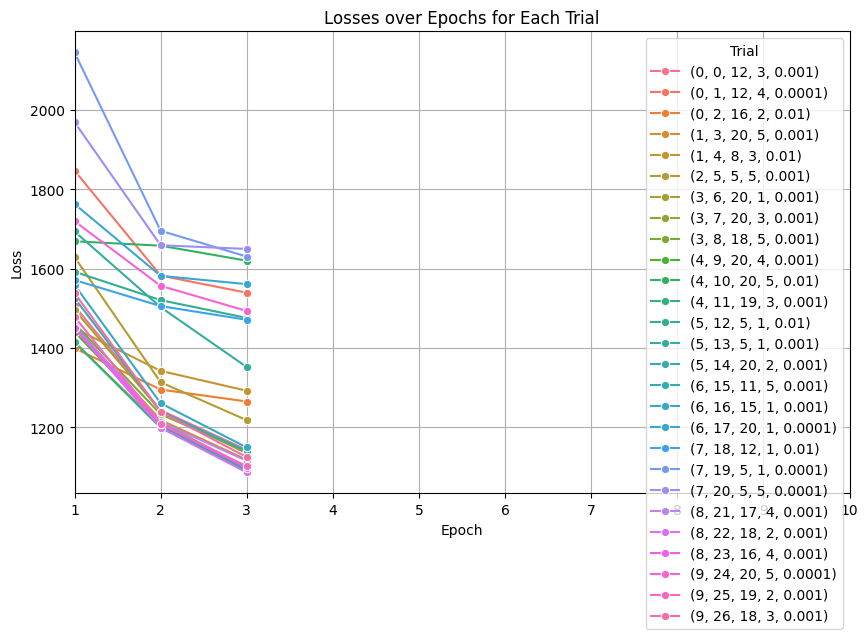

In [ ]:
# Prepare data for plotting
plot_data = []
for trial_idx, trial_losses in losses.items():
    for epoch, loss_val in enumerate(trial_losses):
        plot_data.append({'Trial': trial_idx, 'Epoch': epoch + 1, 'Loss': loss_val})

df_losses = pd.DataFrame(plot_data)

# Plotting the losses
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Trial', marker='o')
plt.title('Losses over Epochs for Each Trial')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xlim(1, 10) # Set x-axis limit to 10 epochs
plt.show()

In [ ]:
lowest_loss = float('inf')
best_hyperparameters = None

for (iteration, trial_index, hidden_size, num_layers, learning_rate), trial_losses in losses.items():
    final_loss = trial_losses[-1]  # Get the last recorded loss for the trial
    if final_loss < lowest_loss:
        lowest_loss = final_loss
        best_hyperparameters = {
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'learning_rate': learning_rate
        }

print(f"Lowest final loss: {lowest_loss:.4f}")
print(f"Best hyperparameters: {best_hyperparameters}")

Lowest final loss: 1086.3679
Best hyperparameters: {'hidden_size': 18, 'num_layers': 2, 'learning_rate': 0.001}


In [ ]:
hidden_size = best_hyperparameters["hidden_size"]
num_layers = best_hyperparameters["num_layers"]
learning_rate = best_hyperparameters["learning_rate"]
num_epochs = 10

def create_model(epochs, hidden_size, num_layers, learning_rate, X_train, y_train):
    print("Hyperparameters: ", hidden_size, num_layers, learning_rate)

    dataset = TextDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

    model = GRU_nn(len(vocab), embedding_dim, hidden_size, num_layers, output_size).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

    print("Training completed.")
    return model, total_loss


In [ ]:
model, loss = create_model(num_epochs, hidden_size, num_layers, learning_rate, X_train, y_train)

Hyperparameters:  18 2 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/10], Loss: 1473.4758
Epoch [2/10], Loss: 1221.5091
Epoch [3/10], Loss: 1122.4750
Epoch [4/10], Loss: 1018.2182
Epoch [5/10], Loss: 929.5109
Epoch [6/10], Loss: 839.1839
Epoch [7/10], Loss: 761.7762
Epoch [8/10], Loss: 700.6037
Epoch [9/10], Loss: 629.5820
Epoch [10/10], Loss: 568.2981
Training completed.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Create test dataset and dataloader
test_dataset = TextDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_batch)

# Set model to evaluation mode
model.eval()

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        outputs = model(X)

        # Convert outputs from probabilities (5 columns) to predicted class indices (0-4 for 1-5 satisfaction)
        # Since outputs are sigmoid, they are probabilities for each class. For multi-class, we take the argmax.
        predicted_labels = torch.argmax(outputs, dim=1)

        # Convert one-hot encoded true labels to class indices (0-4 for 1-5 satisfaction)
        true_labels = torch.argmax(y, dim=1)

        all_predictions.extend(predicted_labels.cpu().numpy())
        all_true_labels.extend(true_labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_true_labels, all_predictions, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Accuracy: 0.6495
Precision: 0.6701
Recall: 0.6495


In [ ]:
# Convert one-hot encoded y_train and y_test back to original integer labels (1-5)
y_train_original_labels = torch.argmax(y_train, dim=1) + 1
y_test_original_labels = torch.argmax(y_test, dim=1) + 1

# Define the mapping function for 3 categories
def map_to_3_categories(label):
    if label <= 2:  # 1 or 2 -> Negative (map to 0)
        return 0
    elif label == 3:  # 3 -> Neutral (map to 1)
        return 1
    else:  # 4 or 5 -> Positive (map to 2)
        return 2

# Apply the mapping to create new labels
y_train_3_categories = torch.tensor([map_to_3_categories(l.item()) for l in y_train_original_labels], dtype=torch.long)
y_test_3_categories = torch.tensor([map_to_3_categories(l.item()) for l in y_test_original_labels], dtype=torch.long)

# One-hot encode the new 3-category labels
# num_classes for one-hot encoding should be 3 for 0, 1, 2 categories
y_train_3_categories_oh = F.one_hot(y_train_3_categories, num_classes=3).float()
y_test_3_categories_oh = F.one_hot(y_test_3_categories, num_classes=3).float()

print(f"New y_train shape (3 categories): {y_train_3_categories_oh.shape}")
print(f"New y_test shape (3 categories): {y_test_3_categories_oh.shape}")

New y_train shape (3 categories): torch.Size([8559, 3])
New y_test shape (3 categories): torch.Size([2140, 3])


In [ ]:
output_size = 3
model, loss = create_model(num_epochs, hidden_size, num_layers, learning_rate, X_train, y_train_3_categories_oh)

Hyperparameters:  18 2 0.001


/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch [1/10], Loss: 1553.6845
Epoch [2/10], Loss: 1108.0850
Epoch [3/10], Loss: 915.2208
Epoch [4/10], Loss: 753.9695
Epoch [5/10], Loss: 614.8787
Epoch [6/10], Loss: 469.5770
Epoch [7/10], Loss: 378.6422
Epoch [8/10], Loss: 285.9839
Epoch [9/10], Loss: 226.4676
Epoch [10/10], Loss: 176.7563
Training completed.


In [ ]:
test_dataset = TextDataset(X_test, y_test_3_categories_oh)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_batch)

# Set model to evaluation mode
model.eval()

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        outputs = model(X)
        predicted_labels = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(y, dim=1)

        all_predictions.extend(predicted_labels.cpu().numpy())
        all_true_labels.extend(true_labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_true_labels, all_predictions, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

/tmp/ipython-input-2103488482.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-2103488482.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Accuracy: 0.7841
Precision: 0.8117
Recall: 0.7841
